# Modelling of predictions

**Analysis steps:**

1. [📓 Questionnaire processing.ipynb](<Questionnaire%20processing.ipynb>)
2. [📓 Factor analysis.ipynb](<Factor%20analysis.ipynb>)
3. [📓 Prediction analysis.ipynb](<Prediction%20analysis.ipynb>)
4. ▶ **[📓 Prediction modelling.ipynb](<Prediction%20modelling.ipynb>)**

This notebook contains code for computational models of prediction data.


## Imports

In [1]:
import os

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from pingouin import mediation_analysis
from stats_utils.regression.analysis import sequential_regression
from stats_utils.regression.plotting import forest_plot, plot_r2s

from interactive_avoidance.analysis import run_exploratory_models
from interactive_avoidance.data import (
    load_all_data,
    load_environment_data,
    load_factor_scores,
    scale_data,
    separate_predator_prey_data,
    sort_dataframes,
)
from interactive_avoidance.utils import (
    plot_regression,
    calculate_and_print_correlations,
    check_directories,
    dataframes_to_markdown, 
    coefficients_to_dataframe
)
from interactive_avoidance.models.action_prediction import fit_prediction_models
from interactive_avoidance.style import set_style

# Check that we're in the right directory
check_directories()

set_style("style.mplstyle")

Changing directory to root directory of repository...
Font saved to: ./fonts
Matplotlib style set to: style.mplstyle with font Heebo


## Load in data

Here we load in both behavioural and questionnare data. We perform some standardisation on the data and check that it looks as it should


In [2]:
# Load in all data
(
    rating_df,
    rt_prey_df,
    rt_predator_df,
    confidence_df,
    prediction_df,
    response_df,
) = load_all_data()

# Separate predator and prey movements
prey_df, predator_df = separate_predator_prey_data(response_df)

# Sort dataframes to keep things tidy
prediction_df, predator_df, prey_df = sort_dataframes(
    [prediction_df, predator_df, prey_df]
)
prediction_df.loc[
    predator_df["cellID"] == -999, "cellID"
] = -999  # Trials where predator caught prey half way through

# Recode environments to start from 0
prediction_df["env"] = prediction_df["env"] - 1
predator_df["env"] = predator_df["env"] - 1
prey_df["env"] = prey_df["env"] - 1

# Load environment data
envs = load_environment_data()

# Check that everything looks as it should
assert np.all(
    prediction_df["subjectID"] == predator_df["subjectID"]
), "Subject ID columns do not match"
assert np.all(
    prediction_df["condition"] == predator_df["condition"]
), "Condition columns do not match"
assert np.all(
    prediction_df["trial"] == predator_df["trial"]
), "Trial columns do not match"
assert np.all(
    prediction_df["response_number"] == predator_df["response_number"]
), "Response number columns do not match"

# Load in factor scores for all solutions
factor_scores = load_factor_scores(5)

# Load in questionnaire data
qdata = pd.read_csv(
    "data/questionnaires/questionnaire_data-reverse_coded-subscales.csv"
)

# Attention checks
qdata = qdata[qdata["attention_check_failed"] < 1]

# Excluding subjects who fail more than one infrequency item check.
qdata = qdata[qdata["inattentive_incorrect"] <= 1]

# we shouldn't have any duplicate rows, but just in case
qdata = qdata.drop_duplicates(["subjectID"])

# Print the number of subjects
print("Task n: {0} subjects".format(prediction_df["subjectID"].nunique()))
print("Questionnaire n: {0} subjects".format(qdata["subjectID"].nunique()))
print("Factor scores n: {0} subjects".format(factor_scores["subjectID"].nunique()))

Dropped 7 subjects with gender != 0 or 1.
Task n: 1019 subjects
Questionnaire n: 1005 subjects
Factor scores n: 989 subjects


## Model fitting

### ❓ Optional: Fit the models

Next we fit the action prediction models. This fits the following models to the data:

1. Policy repetition (_model-free_)
2. Policy learning (_model-free_)
3. Policy learning with generalisation (_model-free_)
4. Goal inference (_model-based_)
5. Goal inference + policy repetition (_model-based_)
6. Goal inference + policy learning (_model-based_)
7. Goal inference + policy learning + generalisation (_model-based_)

> ⚠ The fitting procedure can take a while to run. If you wish to skip this part, you can load in the fitted parameter values in the next cell. By default, the fitting code here is set to run in parallel across 96 cores. If you wish to run this on fewer cores, change the `n_jobs` parameter in the `fit_prediction_models` function call below.


In [3]:
# # Fit prediction models on the provided data
# fit, _ = fit_prediction_models(predator_df, prey_df, prediction_df, envs, n_jobs=96)

# # Format the "model" column in the dataframe for better readability
# fit["model"] = fit["model"].str.replace("_", "\n").str.capitalize()

# # Save the results to a CSV file
# # Check if the directory exists, if not, create it
# if not os.path.isdir("results/task/model_fitting"):
#     os.mkdir("results/task/model_fitting")

# # Save the dataframe to a CSV file
# fit.to_csv("results/task/model_fitting/prediction_model_fit_results.csv", index=None)

### Load in fitted models

If you want to skip the model fitting, you can load in the fitted models here.


In [4]:
# Load in results
fit = pd.read_csv("results/task/model_fitting/prediction_model_fit_results.csv")

### Get best fitting models

We want to determine the best fitting model for each participant. We then get the mean across subjects to determine the best fitting model overall.


In [5]:
# Group the fit data by subjectID and model, then aggregate with sum and reset the index
subject_fit = fit.groupby(["subjectID", "model"]).sum().reset_index()

# Compute the mean of the BIC values for each model and reset the index
BIC_mean = subject_fit.groupby(["model"]).mean(numeric_only=True).reset_index()

/tmp/ipykernel_27416/983746073.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  subject_fit = fit.groupby(["subjectID", "model"]).sum().reset_index()


### Best fitting model

Here we print out the best fitting model.


In [6]:
BIC_mean[BIC_mean["BIC"] == BIC_mean["BIC"].min()]

,model,accuracy,log_lik,BIC,alpha_values,w_values
0,Combined\ngeneralisation,0.504126,-86.943727,182.646506,0.257613,0.215684


### Plot BIC

Next we plot the BIC values for each model as a bar plot, with the BIC values for each subject plotted as points.


/tmp/ipykernel_27416/4096488084.py:17: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(


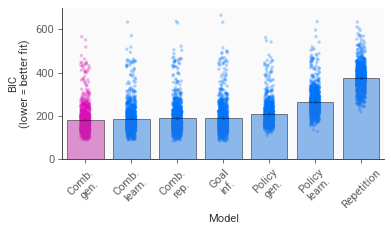

In [7]:
# Extract the default color palette
pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

# Initialize an array with a default color for each model in BIC_mean
colours = np.array([pal[0]] * len(BIC_mean))

# Change the color of the model with the lowest BIC to a highlight color
colours[np.argmin(BIC_mean["BIC"])] = pal[1]

# Convert the numpy array back to a list
colours = list(colours)

# Create a figure and axis
f, ax = plt.subplots(1, 1, figsize=(5, 3))

# Plot individual subject BIC values as strip plot
sns.stripplot(
    x="model",
    y="BIC",
    data=subject_fit,
    dodge=False,
    alpha=0.3,
    ax=ax,
    palette=colours,
    zorder=-1,
    s=3,
)

# Plot mean BIC values as bar plot
sns.barplot(
    x="model",
    y="BIC",
    data=subject_fit,
    alpha=0.5,
    capsize=0.05,
    errwidth=0.8,
    ax=ax,
    palette=colours,
    linewidth=0.8,
    edgecolor="black",
)

# Rotate x tick labels for better visibility
plt.xticks(rotation=45)

# Set axis labels
ax.set_xlabel("Model")
ax.set_ylabel("BIC\n(lower = better fit)")

# Update X tick labels with more descriptive names
model_display_names = [
    "Comb. gen.",
    "Comb. learn.",
    "Comb. rep.",
    "Goal inf.",
    "Policy gen.",
    "Policy learn.",
    "Repetition",
]
model_display_names = [i.replace(" ", "\n") for i in model_display_names]
ax.set_xticklabels(model_display_names)

# Despine for aesthetics and adjust layout
sns.despine()
plt.tight_layout()

# Save
# plt.savefig('../../figures/Figure-3_model_fit.svg')

### Get the best fitting model for each subject

Now we have a measure of model fit for each model and subject, but we ideally want to know which is the best fitting model for each subject.


In [8]:
# Initialize a dictionary to store each subject's best model based on BIC
subject_best_models = {"subjectID": [], "best_model": []}

# Loop through each unique subject
for sub in subject_fit["subjectID"].unique():
    # Filter the dataframe for the current subject
    sub_df = subject_fit[subject_fit["subjectID"] == sub]

    # Append the subject ID to the dictionary
    subject_best_models["subjectID"].append(sub)

    # Identify and append the best model for the current subject based on BIC
    subject_best_models["best_model"].append(sub_df.iloc[sub_df["BIC"].argmin()].model)

# Convert the dictionary to a DataFrame and sort by best_model
subject_best_models = pd.DataFrame(subject_best_models).sort_values("best_model")

# Identify the best model based on the minimum BIC value
best_model = BIC_mean[BIC_mean["BIC"] == BIC_mean["BIC"].min()]["model"].values[0]

# Calculate mean parameters for each subject and model combination
best_model_params = (
    fit.groupby(["subjectID", "model"]).mean(numeric_only=True).reset_index()
)

# Filter the data for the identified best model
best_model_params = best_model_params[best_model_params["model"] == best_model]

# Adjust the 'w_values' column (higher value indicates more model-based behavior)
best_model_params["w_values"] = 1 - best_model_params["w_values"]

# Reshape the DataFrame from wide to long format, focusing on 'alpha_values' and 'w_values'
best_model_params_long = best_model_params.melt(
    "subjectID", ["alpha_values", "w_values"]
)

### Plot parameters from the best fitting model

The best fitting model combines both model-based (goal inference) and model-free (policy learning) components. We can plot the parameters from this model ($\alpha$ = policy learning rate; $W$ = model-based/model-free weighting) to see how they vary across subjects.


/tmp/ipykernel_27416/2453616021.py:5: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(


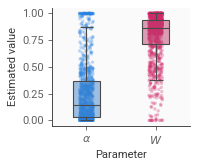

In [9]:
# Set up the figure with a specified size
plt.figure(figsize=(2.5, 2.2))

# Display a strip plot showing individual parameter values with reduced opacity
sns.stripplot(
    x="variable",
    y="value",
    data=best_model_params_long,
    alpha=0.3,
    zorder=-1,
    size=3,
    palette=["#2782e3", "#d12869"],
)

# Overlay with a box plot showing parameter value distribution
ax = sns.boxplot(
    x="variable",
    y="value",
    data=best_model_params_long,
    width=0.4,
    fliersize=0,
    zorder=100,
    palette=["#2782e3", "#d12869"],
)

# Adjust the boxplot's transparency
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.5))

# Set custom labels for x-axis ticks
ax.set_xticklabels([r"$\alpha$", "$W$"])

# Set x and y axis labels
ax.set_xlabel("Parameter")
ax.set_ylabel("Estimated value")

# Remove top and right borders of the plot for aesthetics
sns.despine()

# Adjust the plot layout
plt.tight_layout()

# Save
# plt.savefig('../../figures/Figure-3_param_values.svg')

In [25]:
best_model_params['w_values'].describe()

count    1019.000000
mean        0.784316
std         0.227508
min         0.000000
25%         0.711508
50%         0.862431
75%         0.935650
max         1.000000
Name: w_values, dtype: float64

### Calculate relative model fit

It can be helpful to use _relativey_ model fit rather than absolute model fit, as absolute fit can be influenced by general noise in the data rather than a specific model's fit. We therefore calculate the relative model fit for each model and subject, comparing:

1. Goal inference vs. policy learning - gives an idea of how model based the participant is
2. Combined generalisation vs. goal inference - gives an idea of the extent to which someone is using the combination of policy learning with generalisation and goal inference versus pure goal inference.


In [10]:
# Calculate the relative BIC difference between Policy generalisation and the combined generalisation model
relative_BIC = (
    subject_fit[subject_fit["model"] == "Policy\ngeneralisation"]
    .sort_values("subjectID")["BIC"]
    .values
    - subject_fit[subject_fit["model"] == "Combined\ngeneralisation"]
    .sort_values("subjectID")["BIC"]
    .values
)
# Assign the calculated difference to the 'relative_BIC' column
best_model_params["relative_BIC"] = relative_BIC

# Define a list of parameter names for further processing
parameter_names = [
    "relative_BIC",
    "w_values",
]

### Merge the model-fitting data with the questionnaire data

Next we combine the parameter estimates and model fit statistics for each subject with the questionnaire data.


In [11]:
# merge factor scores with parameter estimates
parameters_mh_measures = pd.merge(best_model_params, factor_scores, on="subjectID")

# merge with qdata
parameters_mh_measures = pd.merge(
    parameters_mh_measures, qdata.drop(columns=["age", "gender"]), on="subjectID"
)

# Merge in prediction confidence
prediction_confidence = pd.read_csv("results/task/prediction_confidence.csv")
parameters_mh_measures = pd.merge(
    prediction_confidence[["subjectID", "p_correct", "confidence", "p_correct_raw"]],
    parameters_mh_measures,
    on="subjectID",
)

# Cube transform the W parameter values because they're very skewed
parameters_mh_measures_scaled = parameters_mh_measures.copy()
parameters_mh_measures_scaled["w_values"] = (
    parameters_mh_measures_scaled["w_values"] ** 3
)

# Scale columns to have 0 mean and 1 SD without using scale_data
for col in parameters_mh_measures_scaled.columns:
    if col not in ["subjectID", "model", "gender"]:
        parameters_mh_measures_scaled[col] = (
            parameters_mh_measures_scaled[col]
            - parameters_mh_measures_scaled[col].mean(numeric_only=True)
        ) / parameters_mh_measures_scaled[col].std(numeric_only=True)

W (Pearson): r (982) = 0.41, p = 0.000
W (Spearman): rho (982) = 0.40, p = 0.000
Delta BIC (Pearson): r (982) = 0.42, p = 0.000
Delta BIC (Spearman): rho (982) = 0.42, p = 0.000


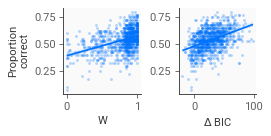

In [27]:
# Create a 1x2 subplot grid with specified size
f, ax = plt.subplots(1, 2, figsize=(3.4, 1.8))

# Plot regressions
plot_regression(
    ax[0],
    parameters_mh_measures,
    "w_values",
    "p_correct_raw",
    "W",
    "Proportion\ncorrect",
)
plot_regression(
    ax[1], parameters_mh_measures, "relative_BIC", "p_correct_raw", r"$\Delta$ BIC"
)

# Remove the top and right spines for a cleaner look
sns.despine()

# Calculate and print correlations
calculate_and_print_correlations(parameters_mh_measures, "w_values", "p_correct", "W")
calculate_and_print_correlations(
    parameters_mh_measures, "relative_BIC", "p_correct", "Delta BIC"
)

# Adjust layout to ensure subplots do not overlap
plt.tight_layout()

## Associations between model fit and questionnaire scores

### Run sequential regressions

Finally, we look at the associations between model fit and questionnaire scores. We focus on indices of "model-basedness":

1. The relative model fit between goal inference + policy learning with generalisation (the winning model) and policy learning with generalisation alone (i.e., with no model-based component).
2. The value of the $W$ parameter in the winning model, which determines the relative weighting of model-based and model-free components.

Here we run sequential regression models to determine how much variance in our behavioural measures is explained when we add lower-level symptom dimensions.


[0.04, 0.04, 0.04, 0.04, 0.07]
[0.03, 0.03, 0.04, 0.04, 0.06]


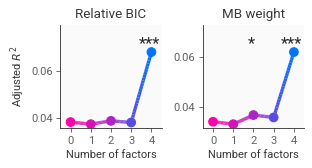

In [28]:
# Define parameter display names for plotting
param_display_names = ["Relative BIC", "MB weight"]

# Initialize a dictionary to store model outputs
model_outputs = {}

# Run sequential regression for each parameter and store the results in `model_outputs`
for p in parameter_names:
    model_outputs[p] = sequential_regression(
        parameters_mh_measures_scaled,
        p,
        n_solutions=4,
        covariates=["age", "gender", "motivation"],
        n_bootstraps=20000,
    )

# Create a subplot layout based on the number of parameters
f, ax = plt.subplots(1, len(parameter_names), figsize=(2 * len(parameter_names), 2.2))

# Plot the R^2 values for each parameter
for i, p in enumerate(parameter_names):
    plot_r2s(
        model_outputs[p], ax=ax[i], show_ylabel=i == 0
    )  # Only show y-axis label for the first subplot
    ax[i].set_title(
        param_display_names[i]
    )  # Set the title based on parameter display names

    # Print the R2s
    print([np.round(i, 2) for i in model_outputs[p].r2s])

# Remove top and right spines for a cleaner look
sns.despine()

# Save
plt.savefig("figures/action_prediction_model_r2.svg", bbox_inches="tight")

In [14]:
model_outputs_anova = {}

for v in model_outputs.keys():

    model_outputs_anova[v] = model_outputs[v].anova_results[['df_resid', 'ssr', 'ss_diff', 'F', 'Pr(>F)']]
    print(v)
    print(model_outputs_anova[v].round(
        {
            "df_resid": 0,
            "ssr": 2,
            "ss_diff": 2,
            "F": 2,
            "Pr(>F)": 3,
        }
    ))

relative_BIC
   df_resid     ssr  ss_diff      F  Pr(>F)
0     979.0  941.34      NaN    NaN     NaN
1     978.0  941.25     0.09   0.10   0.752
2     977.0  938.92     2.33   2.50   0.114
3     976.0  938.62     0.30   0.32   0.573
4     975.0  908.55    30.07  32.27   0.000
w_values
   df_resid     ssr  ss_diff      F  Pr(>F)
0     979.0  945.46      NaN    NaN     NaN
1     978.0  945.44     0.02   0.02   0.897
2     977.0  940.92     4.53   4.83   0.028
3     976.0  940.88     0.04   0.04   0.844
4     975.0  914.41    26.47  28.22   0.000


### Look at the coefficients from the model

Finally, we plot the coefficients from the model to see which symptom dimensions are associated with model-basedness.


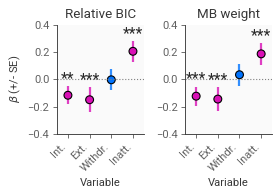

In [15]:
# Display names
param_display_names = ["Relative BIC", "MB weight"]

factor_name_dict = {
    "Sol4_ML1": "Int.",
    "Sol4_ML2": "Ext.",
    "Sol4_ML3": "Withdr.",
    "Sol4_ML4": "Inatt.",
}

f, ax = plt.subplots(
    1,
    len(parameter_names),
    figsize=(1.8 * len(parameter_names), 2.55),
    gridspec_kw={"width_ratios": [2, 2]},
)

for i, p in enumerate(parameter_names):
    # plot the coefficients for each model, using the best number of components
    r2_change = model_outputs[p].anova_results["Pr(>F)"] < 0.05

    if np.any(r2_change):
        model_idx = np.where(model_outputs[p].anova_results["Pr(>F)"] < 0.05)[0][-1]
        forest_plot(
            model_outputs[p].models[model_idx],
            ax=ax[i],
            rename_dict=factor_name_dict,
            exclude_param_names=["age", "gender", "motivation"],
        )
    else:
        forest_plot(model_outputs[p].models[0], ax=ax[i])

    # make sure all plots have the same y-axis limits
    ax[i].set_ylim([-0.4, 0.4])

    # Set title
    ax[i].set_title(param_display_names[i])

    # Remove Y axis label for all but the first plot
    if i > 0:
        ax[i].set_ylabel("")

plt.tight_layout()

# Save
plt.savefig("figures/action_prediction_model_forest.svg", bbox_inches="tight")

### Exploratory analyses

We also run some exploratory analyses to see whether the model-basedness measures are associated with other symptom measures, correcting for multiple comparisons across all of the measures.


In [16]:
parameters_exploratory = run_exploratory_models(parameter_names, parameters_mh_measures, n_bootstraps=20000)
parameters_exploratory

,parameter,measure,coef,coef_se,t,p,ci_lower,ci_upper,p_fdr
0,relative_BIC,AQ_10,0.284913,0.150815,1.889151,0.0715,-0.022077,0.590581,0.41300
1,relative_BIC,STICSA_T,-0.036807,0.060940,-0.603985,0.5595,-0.158920,0.090722,0.93250
2,relative_BIC,LSAS,-0.001278,0.044242,-0.028879,0.9722,-0.092556,0.090556,0.97220
3,relative_BIC,PHQ_8,-0.126963,0.154038,-0.824228,0.4016,-0.425534,0.170215,0.80320
4,relative_BIC,GAD_7,-0.289543,0.155973,-1.856365,0.0826,-0.607360,0.039640,0.41300
5,w_values,AQ_10,0.001863,0.001659,1.123431,0.2441,-0.001251,0.004985,0.77875
6,w_values,STICSA_T,0.000045,0.000670,0.066786,0.9292,-0.001384,0.001499,0.97220
7,w_values,LSAS,-0.000018,0.000486,-0.036846,0.9720,-0.001013,0.000987,0.97220
8,w_values,PHQ_8,-0.000422,0.001587,-0.266136,0.7809,-0.003548,0.002649,0.97220
9,w_values,GAD_7,-0.001764,0.001607,-1.097632,0.3115,-0.005251,0.001578,0.77875


## Mediation analysis

Finally, we run a mediation analysis to see whether the association between symptom dimensions and prediction accuracy is mediated by the tendency to use a model-based strategy in the task.

### W parameter as mediator


In [32]:
# Set up covariates
covar = ["Sol4_ML1", "Sol4_ML2", "Sol4_ML3", "age", "gender", "motivation"]

# Run the model
w_values_mediation_inattentive = mediation_analysis(
    data=parameters_mh_measures_scaled,
    x="Sol4_ML4",
    m=["w_values"],
    y="p_correct",
    covar=covar,
    alpha=0.05,
    seed=42,
    n_boot=20000,
)
w_values_mediation_inattentive

,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,w_values ~ X,0.185897,0.040033,3.891358e-06,0.107337,0.264457,Yes
1,Y ~ w_values,0.388806,0.029558,1.689185e-36,0.330802,0.446810,Yes
2,Total,0.193216,0.040058,1.636559e-06,0.114607,0.271826,Yes
3,Direct,0.123613,0.037576,1.038877e-03,0.049874,0.197352,Yes
4,Indirect,0.069603,0.016821,0.000000e+00,0.038178,0.104178,Yes


The indirect is significant, indicating that the association between symptom dimensions and prediction accuracy is mediated by the tendency to use a model-based strategy in the task. However, the direct effect is also significant, indicating that the association is not fully mediated by model-basedness.


In [33]:
# Set up covariates
covar = ["Sol4_ML4", "Sol4_ML2", "Sol4_ML3", "age", "gender", "motivation"]

# Run the model
w_values_mediation_ext = mediation_analysis(
    data=parameters_mh_measures_scaled,
    x="Sol4_ML1",
    m=["w_values"],
    y="p_correct",
    covar=covar,
    alpha=0.05,
    seed=42,
    n_boot=20000,
)
w_values_mediation_ext

,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,w_values ~ X,-0.124275,0.035298,4.501959e-04,-0.193542,-0.055007,Yes
1,Y ~ w_values,0.377138,0.029541,1.257769e-34,0.319167,0.435109,Yes
2,Total,-0.073453,0.035320,3.781753e-02,-0.142765,-0.004142,Yes
3,Direct,-0.026923,0.032979,4.144890e-01,-0.091640,0.037795,No
4,Indirect,-0.046531,0.014093,6.000000e-04,-0.075455,-0.019746,Yes


We see a similar pattern with externalising as the independent variable, although the direct effect is not significant indicating that the association is fully mediated by model-basedness.

### Relative model fit as mediator


In [34]:
# Set up covariates
covar = ["Sol4_ML1", "Sol4_ML2", "Sol4_ML3", "age", "gender", "motivation"]

# Run the model
bic_values_mediation_inattentive = mediation_analysis(
    data=parameters_mh_measures_scaled,
    x="Sol4_ML4",
    m=["relative_BIC"],
    y="p_correct",
    covar=covar,
    alpha=0.05,
    seed=42,
    n_boot=20000,
)
bic_values_mediation_inattentive

,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,relative_BIC ~ X,0.204644,0.039904,3.523939e-07,0.126337,0.282952,Yes
1,Y ~ relative_BIC,0.396074,0.029488,7.308966e-38,0.338207,0.453941,Yes
2,Total,0.193216,0.040058,1.636559e-06,0.114607,0.271826,Yes
3,Direct,0.115188,0.037572,2.230617e-03,0.041457,0.188918,Yes
4,Indirect,0.078029,0.016380,0.000000e+00,0.047583,0.111434,Yes


The results look much the same when we use the relative model fit as the mediator.


In [35]:
# Set up covariates
covar = ["Sol4_ML4", "Sol4_ML2", "Sol4_ML3", "age", "gender", "motivation"]

# Run the model
bic_values_mediation_ext = mediation_analysis(
    data=parameters_mh_measures_scaled,
    x="Sol4_ML1",
    m=["relative_BIC"],
    y="p_correct",
    covar=covar,
    alpha=0.05,
    seed=42,
    n_boot=20000,
)
bic_values_mediation_ext

,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,relative_BIC ~ X,-0.117535,0.035184,8.677804e-04,-0.186580,-0.048490,Yes
1,Y ~ relative_BIC,0.384047,0.029583,1.157207e-35,0.325994,0.442100,Yes
2,Total,-0.073453,0.035320,3.781753e-02,-0.142765,-0.004142,Yes
3,Direct,-0.028638,0.032876,3.839158e-01,-0.093155,0.035878,No
4,Indirect,-0.044815,0.013739,9.000000e-04,-0.072949,-0.019119,Yes


Again, this indicates that the externalising > accuracy relationship is fully mediated by model-basedness.

## Combine all figures


/tmp/ipykernel_27416/2952606686.py:18: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(
/home/tobywise/miniconda3/envs/ia_env/lib/python3.8/site-packages/stats_utils/regression/plotting.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/home/tobywise/miniconda3/envs/ia_env/lib/python3.8/site-packages/stats_utils/regression/plotting.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


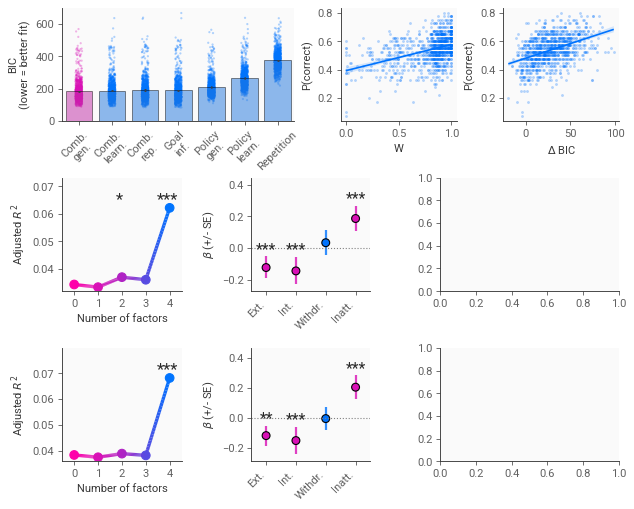

In [19]:
rename_dict = {
    "Sol4_ML1": "Ext.",
    "Sol4_ML2": "Int.",
    "Sol4_ML3": "Withdr.",
    "Sol4_ML4": "Inatt.",
}

fig = plt.figure(figsize=(8, 7))
gs0 = fig.add_gridspec(3, 1, height_ratios=[1, 1, 1], hspace=0.5)

gs00 = gs0[0].subgridspec(1, 3, width_ratios=[2, 1, 1], wspace=0.3)

ax = [plt.subplot(gs00[0, i]) for i in range(3)]

# model fits
sns.stripplot(
    x="model",
    y="BIC",
    data=subject_fit,
    dodge=False,
    alpha=0.3,
    ax=ax[0],
    palette=colours,
    zorder=-1,
    s=2,
)
sns.barplot(
    x="model",
    y="BIC",
    data=subject_fit,
    alpha=0.5,
    capsize=0.05,
    errwidth=0.8,
    ax=ax[0],
    palette=colours,
    linewidth=0.8,
    edgecolor="black",
)
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45)
ax[0].set_xlabel("")
ax[0].set_ylabel("BIC\n(lower = better fit)")

max_bic = subject_fit["BIC"].max()
min_bic = subject_fit["BIC"].min()

# update X tick labels
ax[0].set_xticklabels(model_display_names)

sns.despine()

# Correlation between W and p correct
sns.regplot(
    x="w_values",
    y="p_correct_raw",
    data=parameters_mh_measures,
    scatter_kws={"alpha": 0.2, "s": 3},
    ax=ax[1],
)

ax[1].set_xlabel("W")
ax[1].set_ylabel("P(correct)")

sns.despine()

# Correlation between relative BIC and p correct
sns.regplot(
    x="relative_BIC",
    y="p_correct_raw",
    data=parameters_mh_measures,
    scatter_kws={"alpha": 0.2, "s": 3},
    ax=ax[2],
)

ax[2].set_xlabel("$\Delta$ BIC")
ax[2].set_ylabel("P(correct)")

sns.despine()

# W effects

gs01 = gs0[1].subgridspec(1, 3, width_ratios=[1, 1, 1.5], wspace=0.5)

ax = [plt.subplot(gs01[0, i]) for i in range(3)]

plot_r2s(model_outputs["w_values"], ax=ax[0])

# remove title
ax[0].set_title("")

forest_plot(
    model_outputs["w_values"].models[4],
    rename_dict=rename_dict,
    ax=ax[1],
    show_xlabel=False,
    exclude_param_names=["age", "gender", "motivation"],
)

# Relative BIC

gs02 = gs0[2].subgridspec(1, 3, width_ratios=[1, 1, 1.5], wspace=0.5)

ax = [plt.subplot(gs02[0, i]) for i in range(3)]

plot_r2s(model_outputs["relative_BIC"], ax=ax[0])

# remove title
ax[0].set_title("")

forest_plot(
    model_outputs["relative_BIC"].models[4],
    rename_dict=rename_dict,
    ax=ax[1],
    show_xlabel=False,
    exclude_param_names=["age", "gender", "motivation"],
)


# Save
if not os.path.exists("figures/combined"):
    os.makedirs("figures/combined")
plt.savefig("figures/combined/figure4.svg", bbox_inches="tight")
plt.savefig("figures/combined/figure4.pdf", bbox_inches="tight")

## Combine and export tables

Finally we export the tables containing model comparison results and coefficients for use in the manuscript.

### Model comparison results

In [20]:
# Rounding for each column
round_dict = {
    "df_resid": 0,
    "ssr": 2,
    "ss_diff": 2,
    "F": 2,
    "Pr(>F)": 3,
}

# Tidier names for each column
column_rename_dict = {
    "df_resid": "$df_{R}$",
    "ssr": "$SS_{R}$",
    "ss_diff": "$SS_{diff}$",
    "F": "$F$",
    "Pr(>F)": "$p$",
}

# Glossary of terms
terms = "$df_{R}$ = residual degrees of freedom, $SS_{R}$ = residual sum of squares, $SS_{diff}$ = difference in residual sum of squares between models, $F$ = F-statistic, $p$ = p-value."

# Create paper directory if it doesn't exist
if not os.path.exists("paper"):
    os.makedirs("paper")

# Save to markdown
dataframes_to_markdown(
    [
        model_outputs_anova['relative_BIC'],
        model_outputs_anova['w_values'],
    ],
    [
        f"Model comparison results for regression models predicting relative fit of model-based and model-free models of movement prediction. {terms}",
        f"Model comparison results for regression models predicting model-based weighting parameter values from winning behavioural model. {terms}",
    ],
    [round_dict] * 2,
    [column_rename_dict] * 2,
    ["Pr(>F)"] * 2,
    "paper/supplementary_tables.md",
    append=True
)

Appending to existing file: paper/supplementary_tables.md


### Coefficients

In [21]:
# Dictionary to rename variables
coef_rename_dict = {
    "Intercept": "Intercept",
    "age": "Age",
    "gender": "Gender",
    "motivation": "Motivation",
    "Sol4_ML1": "Externalising",
    "Sol4_ML2": "Internalising",
    "Sol4_ML3": "Withdrawal",
    "Sol4_ML4": "Inattention",
}

# Convert coefficient tables to DataFrames
coef_dfs = [
    coefficients_to_dataframe(i, rename_dict=coef_rename_dict) for i in model_outputs.values()
]

# Rounding for coef table
coef_round_dict = {
    "coef": 2,
    "std err": 2,
    "t": 2,
    "P>|t|": 3,
    "[0.025": 2,
    "0.975]": 2,
}

# Rename columns
coef_column_rename_dict = {
    "coef": "$\\beta$",
    "std err": "$\\beta_{SE}$",
    "t": "$t$",
    "P>|t|": "$p$",
    "[0.025": "$CI_{2.5}$",
    "0.975]": "$CI_{97.5}$",
}

# Glossary of terms
terms = "$\\beta$ = regression coefficient, $\\beta_{SE}$ = standard error of regression coefficient, $t$ = t-statistic, $p$ = p-value, $CI_{2.5}$ = 95% confidence interval lower bound, $CI_{97.5}$ = 95% confidence interval upper bound."

# Write to markdown file
dataframes_to_markdown(
    coef_dfs,
    [
        f"Coefficients for winning regression model predicting relative fit of model-based and model-free models of movement prediction. {terms}",
        f"Coefficients for winning regression model predicting model-based weighting parameter values from winning behavioural model. {terms}",
    ],
    [coef_round_dict] * len(coef_dfs),
    [coef_column_rename_dict] * len(coef_dfs),
    ["P>|t|"] * len(coef_dfs),
    "paper/supplementary_tables.md",
    append=True,
)

Appending to existing file: paper/supplementary_tables.md


### Mediation models

In [39]:
# Rounding for each column
round_dict = {
    "coef": 2,
    "se": 2,
    "pval": 3,
    "CI[2.5%]": 2,
    "CI[97.5%]": 2,
}

# Tidier names for each column
# path	coef	se	pval	CI[2.5%]	CI[97.5%]
column_rename_dict = {
    "path": "Path",
    "coef": "$\\beta$",
    "se": "$\\beta_{SE}$",
    "pval": "$p$",
    "CI[2.5%]": "$CI_{2.5}$",
    "CI[97.5%]": "$CI_{97.5}$",
}

# Glossary of terms
terms = "$\\beta$ = regression coefficient, $\\beta_{SE}$ = standard error of regression coefficient, $t$ = t-statistic, $p$ = p-value, $CI_{2.5}$ = 95% confidence interval lower bound, $CI_{97.5}$ = 95% confidence interval upper bound."

# Rename variables
rename_dict_inattentive = {
    "relative_BIC ~ X": "Model fit difference ~ Inattention",
    "Y ~ relative_BIC": "Proportion correct ~ Model fit difference",
    "w_values ~ X": "Model-based weighting ~ Inattention",
    "Y ~ w_values": "Proportion correct ~ Model-based weighting",
}

rename_dict_ext = {
    "relative_BIC ~ X": "Model fit difference ~ Externalising",
    "Y ~ relative_BIC": "Proportion correct ~ Model fit difference",
    "w_values ~ X": "Model-based weighting ~ Externalising",
    "Y ~ w_values": "Proportion correct ~ Model-based weighting",
}

# Save to markdown
dataframes_to_markdown(
    [
        bic_values_mediation_inattentive.replace(rename_dict).iloc[:, :-1],
        w_values_mediation_inattentive.replace(rename_dict).iloc[:, :-1],
        bic_values_mediation_ext.replace(rename_dict_ext).iloc[:, :-1],
        w_values_mediation_ext.replace(rename_dict_ext).iloc[:, :-1],
    ],
    [
        f"Mediation model examining mediation of the inattention > prediction accuracy association by model-basedness (as measured by difference in model fit between model-based and model-free strategies). {terms}",
        f"Mediation model examining mediation of the inattention > prediction accuracy association by model-basedness (as measured by difference in model-based weightin parameter values). {terms}",
        f"Mediation model examining mediation of the externalising > prediction accuracy association by model-basedness (as measured by difference in model fit between model-based and model-free strategies). {terms}",
        f"Mediation model examining mediation of the externalising > prediction accuracy association by model-basedness (as measured by difference in model-based weightin parameter values). {terms}",
    ],
    [round_dict] * 4,
    [column_rename_dict] * 4,
    ["pval"] * 4,
    "paper/supplementary_tables.md",
    append=True
)

Appending to existing file: paper/supplementary_tables.md


### Exploratory models

In [40]:
# Rounding for coef table
exp_round_dict = {
    "coef": 2,
    "coef_se": 2,
    "t": 2,
    "p": 3,
    "p_fdr": 3,
    "ci_lower": 2,
    "ci_upper": 2,
}

# Rename columns
exp_column_rename_dict = {
    "parameter": "Parameter",
    "measure": "Measure",
    "coef": "$\\beta$",
    "coef_se": "$\\beta_{SE}$",
    "t": "$t$",
    "p": "$p$",
    "p_fdr": "$p_{FDR}$",
    "ci_lower": "$CI_{2.5}$",
    "ci_upper": "$CI_{97.5}$",
}

# Glossary of terms
terms = (
    "$t$ = t-statistic, $df$ = degrees of freedom, $p$ = p-value, $p_{FDR}$ = false discovery rate corrected p-value"
    ", AQ-10 = Autism Spectrum Quotient, STICSA-T = State Trait Inventory of Cognitive and Somatic Anxiety, LSAS = Liebowitz "
    "Social Anxiety Scale, PHQ-8 = Patient Health Questionnaire, GAD-7 = Generalized Anxiety Disorder Assessment"
)

# Dataframes
all_coefs = parameters_exploratory
all_coefs["measure"] = all_coefs["measure"].str.replace("_", "-")
all_coefs["parameter"] = all_coefs["parameter"].replace(
    {
        "relative_BIC": "Relative model-based model fit",
        "w_values": "Model-based weighting parameter",
    }
)

# Write to markdown file
dataframes_to_markdown(
    [all_coefs],
    [
        f"Coefficients for additional measures predicting different aspects of behaviour, taken from regression models including the same covariates as the primary models. {terms}",
    ],
    [exp_round_dict],
    [exp_column_rename_dict],
    ["p_fdr"],
    "paper/supplementary_tables.md",
    append=True,
    repeated_value_columns=[['parameter']]
)

Appending to existing file: paper/supplementary_tables.md
